# Testing Advanced Snapping
Running travel time to closest facility for health facilities, schools, and markets. Based off of: https://github.com/ywnch/toolbox/blob/master/demo_connect_poi.ipynb

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import networkx as nx
import numpy as np
from shapely.geometry import Point
from shapely.ops import split, unary_union
from shapely.geometry import box, Point

In [3]:
import os, sys

In [4]:
# Get reference to GOSTNets
import sys
sys.path.append(r'C:\repos\GOSTnets')
import GOSTnets as gn

In [ ]:
from toolbox import connect_poi

In [5]:
# import extent
bounds = gpd.read_file("POLYGON.shp")

In [6]:
# define road graph
roadGraph = "OSM_Roads.pickle"

## Use OSMNX to download road network inside bounding box

In [7]:
if not os.path.exists(roadGraph):
    extent = box(*bounds.total_bounds)
    G = ox.graph_from_polygon(extent, network_type = 'drive_service')
    
    # This is how time is calculated from the OSMNX length attribute
    G = gn.convert_network_to_time(G, 'length')
    
    # Find the largest sub-graph compatible with NetworkX 2.4
    list_of_subgraphs = list(G.subgraph(c).copy() for c in nx.strongly_connected_components(G))
    max_graph = None
    max_edges = 0
    for i in list_of_subgraphs:
        if i.number_of_edges() > max_edges:
            max_edges = i.number_of_edges()
            max_graph = i

    # set your graph equal to the largest sub-graph
    G = max_graph
    
    print('print G')
    nx.write_gpickle(G, roadGraph)
else:
    G = nx.read_gpickle(roadGraph)    
    G = gn.convert_network_to_time(G, 'length')

C:\repos\GOSTnets\GOSTnets\core.py:795: UserWarning: Aree you sure you want to convert length to time? This graph already has a time attribute
  warnings.warn('Aree you sure you want to convert length to time? This graph already has a time attribute')


In [8]:
G

### To note: GOSTNets has similiar functions to OSMNX for saving and reading graphs. 

#### GOSTNets

- gn.save internally calls node_gdf_from_graph (also edge_gdf_from_graph), then on the node_gdf_from_graph saves as a CSV by calling GeoPandas's to_csv

- gn.node_gdf_from_graph Function generates a GeoDataFrame from Graph. It loops through each node in the graph (for u, data in G.nodes). It is similar to OSMNX's utils_graph.graph_to_gdfs function, but is a little more flexible.

- GOSTNets doesn't have a function to save a graph as a shapefile

#### OSMNX

- ox.save_graph_shapefile internally calls utils_graph.graph_to_gdfs, then on the gdf calls to_file thus saving as a shapefile

- OSMNX also has a graph_from_gdfs function, this reads in node & edge GeoDataFrames into a graph

- OSMNX doesn't have a function to read in CSVs into a graph, but GOSTNet does: gn.edges_and_nodes_csv_to_graph

There is a slight difference in how GOSTNets and OSMNX read and write graphs. OSMNX uses "u", "v", "key" as the index, while GOSTNet uses only "u", "v". 

### Load POIs

In [ ]:
# insert POIs
POIs = gpd.read_file("POINT.shp")
POIs['key'] = POIs.index

In [ ]:
POIs

In [9]:
#ox.save_graph_shapefile?

In [10]:
# The directed flag is only in newer versions of OSMNX
#ox.save_graph_shapefile(G, filepath='sample/', encoding='utf-8', directed=True)
ox.save_graph_shapefile(G, filepath='sample/', encoding='utf-8')

In [26]:
# try saving using GOSTNets as csv
gn.save(G, 'saved_by_gostnets', 'sample/', pickle = False, edges = True, nodes = True)

In [11]:
# load as GeoDataFrame
nodes = gpd.read_file('sample/nodes.shp')
edges = gpd.read_file('sample/edges.shp')

In [15]:
node_gdf = gn.node_gdf_from_graph(G)
node_gdf

node_ID       osmid          x          y         highway  \
0       63388025    63388025 -77.553658  38.917038  turning_circle   
1       63388033    63388033 -77.553001  38.916946             NaN   
2       63388042    63388042 -77.552197  38.916792  turning_circle   
3       63388052    63388052 -77.527082  38.912955             NaN   
4       63388054    63388054 -77.525910  38.912931             NaN   
...          ...         ...        ...        ...             ...   
7937  8319821715  8319821715 -77.597520  38.922503             NaN   
7938  8319845721  8319845721 -77.597146  38.922459             NaN   
7939  8319845729  8319845729 -77.597512  38.922352             NaN   
7940  8319845733  8319845733 -77.599400  38.918454    turning_loop   
7941  8319845742  8319845742 -77.597978  38.919445             NaN   

                        geometry  
0     POINT (-77.55366 38.91704)  
1     POINT (-77.55300 38.91695)  
2     POINT (-77.55220 38.91679)  
3     POINT (-77.52708 38.91295)  
4     POINT (-77.52591 38.91293)  
...                          ...  
7937  POINT (-77.59752 38.92250)  
7938  POINT (-77.59715 38.92246)  
7939  POINT (-77.59751 38.92235)  
7940  POINT (-77.59940 38.91845)  
7941  POINT (-77.59798 38.91945)  

[7942 rows x 6 columns]

In [16]:
nodes

y          x       osmid         highway  \
0     38.917038 -77.553658    63388025  turning_circle   
1     38.916946 -77.553001    63388033            None   
2     38.916792 -77.552197    63388042  turning_circle   
3     38.912955 -77.527082    63388052            None   
4     38.912931 -77.525910    63388054            None   
...         ...        ...         ...             ...   
7937  38.922503 -77.597520  8319821715            None   
7938  38.922459 -77.597146  8319845721            None   
7939  38.922352 -77.597512  8319845729            None   
7940  38.918454 -77.599400  8319845733    turning_loop   
7941  38.919445 -77.597978  8319845742            None   

                        geometry  
0     POINT (-77.55366 38.91704)  
1     POINT (-77.55300 38.91695)  
2     POINT (-77.55220 38.91679)  
3     POINT (-77.52708 38.91295)  
4     POINT (-77.52591 38.91293)  
...                          ...  
7937  POINT (-77.59752 38.92250)  
7938  POINT (-77.59715 38.92246)  
7939  POINT (-77.59751 38.92235)  
7940  POINT (-77.59940 38.91845)  
7941  POINT (-77.59798 38.91945)  

[7942 rows x 5 columns]

In [17]:
len(G.edges)

18998

In [39]:
edge_gdf = gn.edge_gdf_from_graph(G)
edge_gdf

stnode     endnode      highway tunnel      osmid maxspeed bridge  \
0        63388025    63388033  residential    NaN    8799058      NaN    NaN   
1        63388033    63388042  residential    NaN    8799058      NaN    NaN   
2        63388033    63388025  residential    NaN    8799058      NaN    NaN   
3        63388033    63590128  residential    NaN    8817985      NaN    NaN   
4        63388042    63388033  residential    NaN    8799058      NaN    NaN   
...           ...         ...          ...    ...        ...      ...    ...   
18993  8319845729  8319845721  residential    NaN  895061975      NaN    NaN   
18994  8319845733  8319845742  residential    NaN  895061977      NaN    NaN   
18995  8319845742  8319821703  residential    NaN  895061971      NaN    NaN   
18996  8319845742  8319821666  residential    NaN  895061971      NaN    NaN   
18997  8319845742  8319845733  residential    NaN  895061977      NaN    NaN   

      junction      time   mode lanes  oneway access service  \
0          NaN  10.40526  drive   NaN   False    NaN     NaN   
1          NaN  13.19940  drive   NaN   False    NaN     NaN   
2          NaN  10.40526  drive   NaN   False    NaN     NaN   
3          NaN  17.67366  drive   NaN   False    NaN     NaN   
4          NaN  13.19940  drive   NaN   False    NaN     NaN   
...        ...       ...    ...   ...     ...    ...     ...   
18993      NaN   6.19344  drive   NaN    True    NaN     NaN   
18994      NaN  30.23460  drive   NaN   False    NaN     NaN   
18995      NaN  75.83868  drive   NaN   False    NaN     NaN   
18996      NaN  75.35628  drive   NaN   False    NaN     NaN   
18997      NaN  30.23460  drive   NaN   False    NaN     NaN   

                     name  ref   length  \
0         Visionary Court  NaN   57.807   
1         Visionary Court  NaN   73.330   
2         Visionary Court  NaN   57.807   
3           Mastery Place  NaN   98.187   
4         Visionary Court  NaN   73.330   
...                   ...  ...      ...   
18993    Lotus Pond Place  NaN   34.408   
18994     Harlequin Court  NaN  167.970   
18995  Methley Plum Place  NaN  421.326   
18996  Methley Plum Place  NaN  418.646   
18997     Harlequin Court  NaN  167.970   

                                                geometry  
0      LINESTRING (-77.55366 38.91704, -77.55338 38.9...  
1      LINESTRING (-77.55300 38.91695, -77.55274 38.9...  
2      LINESTRING (-77.55300 38.91695, -77.55311 38.9...  
3      LINESTRING (-77.55300 38.91695, -77.55285 38.9...  
4      LINESTRING (-77.55220 38.91679, -77.55231 38.9...  
...                                                  ...  
18993  LINESTRING (-77.59751 38.92235, -77.59748 38.9...  
18994  LINESTRING (-77.59940 38.91845, -77.59931 38.9...  
18995  LINESTRING (-77.59798 38.91945, -77.59823 38.9...  
18996  LINESTRING (-77.59798 38.91945, -77.59778 38.9...  
18997  LINESTRING (-77.59798 38.91945, -77.59830 38.9...  

[18998 rows x 18 columns]

In [24]:
#edges

In [27]:
G2 = gn.edges_and_nodes_gdf_to_graph(node_gdf, edge_gdf, u_tag = 'stnode', v_tag = 'endnode', geometry_tag = 'geometry')

In [23]:
len(G.edges)

18998

In [28]:
G3 = gn.edges_and_nodes_csv_to_graph('sample/saved_by_gostnets_nodes.csv', 'sample/saved_by_gostnets_edges.csv', u_tag = 'stnode', v_tag = 'endnode', geometry_tag = 'geometry')

In [29]:
len(G.edges)

18998

In [101]:
list(G.nodes(data=True))[0]

(63388025,
 {'y': 38.9170384,
  'x': -77.5536578,
  'osmid': 63388025,
  'highway': 'turning_circle'})

In [47]:
edge_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [202]:
# it's a one-liner, but is still at beta at the moment
G_mod, new_nodes = connect_poi(G, POIs, u_tag = 'stnode', v_tag = 'endnode', poi_key_col='key', path=None, threshold=400, measure_crs='epsg:32618')

Building rtree...
Projecting POIs to the network...
Updating internal nodes...
Updating internal edges...
print new_lines
0     LINESTRING (270060.131 4316828.798, 270059.723...
1     LINESTRING (269921.557 4316103.526, 269909.595...
2     LINESTRING (269286.130 4318212.488, 269291.664...
3     LINESTRING (272849.425 4316126.850, 272969.806...
4     LINESTRING (273123.119 4316148.146, 273140.057...
5     LINESTRING (268283.843 4315537.920, 268299.111...
6     LINESTRING (268332.892 4315729.196, 268334.816...
7     LINESTRING (269598.814 4315283.365, 269583.401...
8     LINESTRING (269583.401 4315231.715, 269559.596...
9     LINESTRING (271922.650 4319810.073, 271919.570...
10    LINESTRING (271885.171 4319606.637, 271883.366...
11    LINESTRING (270128.151 4317724.989, 270126.922...
12    LINESTRING (270114.192 4317841.419, 270110.495...
Name: geometry, dtype: geometry
Updating external links...
print new_lines
[<shapely.geometry.linestring.LineString object at 0x0000022E7700AC88>, <sh

In [203]:
#nodes

In [204]:
#edges

In [205]:
edge_gdf = gn.edge_gdf_from_graph(G_mod)
edge_gdf

stnode     endnode tunnel            highway         osmid maxspeed  \
0      63388025    63388033    NaN        residential       8799058      NaN   
1      63388033    63388042    NaN        residential       8799058      NaN   
2      63388033    63388025    NaN        residential       8799058      NaN   
3      63388033    63590128    NaN        residential       8817985      NaN   
4      63388042    63388033    NaN        residential       8799058      NaN   
...         ...         ...    ...                ...           ...      ...   
19006         2  9990000002    NaN  projected_footway  9990000002_2      NaN   
19007         3  9990000003    NaN  projected_footway  9990000003_3      NaN   
19008         4  9990000004    NaN  projected_footway  9990000004_4      NaN   
19009         5  9990000005    NaN  projected_footway  9990000005_5      NaN   
19010         6  9990000006    NaN  projected_footway  9990000006_6      NaN   

      bridge junction  key      time   mode lanes  oneway access service  \
0        NaN      NaN  NaN  10.40526  drive   NaN   False    NaN     NaN   
1        NaN      NaN  NaN  13.19940  drive   NaN   False    NaN     NaN   
2        NaN      NaN  NaN  10.40526  drive   NaN   False    NaN     NaN   
3        NaN      NaN  NaN  17.67366  drive   NaN   False    NaN     NaN   
4        NaN      NaN  NaN  13.19940  drive   NaN   False    NaN     NaN   
...      ...      ...  ...       ...    ...   ...     ...    ...     ...   
19006    NaN      NaN  2.0       NaN    NaN   NaN   False    NaN     NaN   
19007    NaN      NaN  3.0       NaN    NaN   NaN   False    NaN     NaN   
19008    NaN      NaN  4.0       NaN    NaN   NaN   False    NaN     NaN   
19009    NaN      NaN  5.0       NaN    NaN   NaN   False    NaN     NaN   
19010    NaN      NaN  6.0       NaN    NaN   NaN   False    NaN     NaN   

                  name  ref      length  \
0      Visionary Court  NaN   57.807000   
1      Visionary Court  NaN   73.330000   
2      Visionary Court  NaN   57.807000   
3        Mastery Place  NaN   98.187000   
4      Visionary Court  NaN   73.330000   
...                ...  ...         ...   
19006              NaN  NaN  264.897269   
19007              NaN  NaN    8.997843   
19008              NaN  NaN  105.046932   
19009              NaN  NaN  113.132712   
19010              NaN  NaN   99.728076   

                                                geometry  
0      LINESTRING (-77.55366 38.91704, -77.55338 38.9...  
1      LINESTRING (-77.55300 38.91695, -77.55274 38.9...  
2      LINESTRING (-77.55300 38.91695, -77.55311 38.9...  
3      LINESTRING (-77.55300 38.91695, -77.55285 38.9...  
4      LINESTRING (-77.55220 38.91679, -77.55231 38.9...  
...                                                  ...  
19006  LINESTRING (-77.65257 38.96301, -77.65549 38.9...  
19007  LINESTRING (-77.65394 38.97936, -77.65385 38.9...  
19008  LINESTRING (-77.63523 38.99577, -77.63402 38.9...  
19009  LINESTRING (-77.61806 38.96401, -77.61859 38.9...  
19010  LINESTRING (-77.66021 38.95600, -77.65910 38.9...  

[19011 rows x 19 columns]

In [197]:
edge_gdf = gn.edge_gdf_from_graph(G_mod)
edge_gdf

stnode     endnode tunnel            highway         osmid maxspeed  \
0      63388025    63388033    NaN        residential       8799058      NaN   
1      63388033    63388042    NaN        residential       8799058      NaN   
2      63388033    63388025    NaN        residential       8799058      NaN   
3      63388033    63590128    NaN        residential       8817985      NaN   
4      63388042    63388033    NaN        residential       8799058      NaN   
...         ...         ...    ...                ...           ...      ...   
19006         2  9990000002    NaN  projected_footway  9990000002_2      NaN   
19007         3  9990000003    NaN  projected_footway  9990000003_3      NaN   
19008         4  9990000004    NaN  projected_footway  9990000004_4      NaN   
19009         5  9990000005    NaN  projected_footway  9990000005_5      NaN   
19010         6  9990000006    NaN  projected_footway  9990000006_6      NaN   

      bridge junction  key      time   mode lanes  oneway access service  \
0        NaN      NaN  NaN  10.40526  drive   NaN   False    NaN     NaN   
1        NaN      NaN  NaN  13.19940  drive   NaN   False    NaN     NaN   
2        NaN      NaN  NaN  10.40526  drive   NaN   False    NaN     NaN   
3        NaN      NaN  NaN  17.67366  drive   NaN   False    NaN     NaN   
4        NaN      NaN  NaN  13.19940  drive   NaN   False    NaN     NaN   
...      ...      ...  ...       ...    ...   ...     ...    ...     ...   
19006    NaN      NaN  2.0       NaN    NaN   NaN   False    NaN     NaN   
19007    NaN      NaN  3.0       NaN    NaN   NaN   False    NaN     NaN   
19008    NaN      NaN  4.0       NaN    NaN   NaN   False    NaN     NaN   
19009    NaN      NaN  5.0       NaN    NaN   NaN   False    NaN     NaN   
19010    NaN      NaN  6.0       NaN    NaN   NaN   False    NaN     NaN   

                  name  ref      length  \
0      Visionary Court  NaN   57.807000   
1      Visionary Court  NaN   73.330000   
2      Visionary Court  NaN   57.807000   
3        Mastery Place  NaN   98.187000   
4      Visionary Court  NaN   73.330000   
...                ...  ...         ...   
19006              NaN  NaN  340.263817   
19007              NaN  NaN   11.569579   
19008              NaN  NaN  134.950400   
19009              NaN  NaN  145.770933   
19010              NaN  NaN  128.078394   

                                                geometry  
0      LINESTRING (-77.55366 38.91704, -77.55338 38.9...  
1      LINESTRING (-77.55300 38.91695, -77.55274 38.9...  
2      LINESTRING (-77.55300 38.91695, -77.55311 38.9...  
3      LINESTRING (-77.55300 38.91695, -77.55285 38.9...  
4      LINESTRING (-77.55220 38.91679, -77.55231 38.9...  
...                                                  ...  
19006  LINESTRING (-77.65257 38.96301, -77.65549 38.9...  
19007  LINESTRING (-77.65394 38.97936, -77.65385 38.9...  
19008  LINESTRING (-77.63523 38.99577, -77.63402 38.9...  
19009  LINESTRING (-77.61806 38.96401, -77.61859 38.9...  
19010  LINESTRING (-77.66021 38.95600, -77.65910 38.9...  

[19011 rows x 19 columns]

In [167]:
G_mod

In [168]:
list(G_mod.edges)[0]

(63388025, 63388033, 0)

In [169]:
for edge in list(G_mod.edges):
    print(edge)
    print(G_mod.get_edge_data(edge[0],edge[1]))

(63388025, 63388033, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x0000022E5829D408>, 'highway': 'residential', 'tunnel': nan, 'osmid': 8799058, 'maxspeed': nan, 'bridge': nan, 'junction': nan, 'time': 10.405260000000002, 'mode': 'drive', 'lanes': nan, 'oneway': False, 'access': nan, 'service': nan, 'name': 'Visionary Court', 'ref': nan, 'length': 57.807, 'key': nan}}
(63388033, 63388042, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x0000022E5829D1C8>, 'highway': 'residential', 'tunnel': nan, 'osmid': 8799058, 'maxspeed': nan, 'bridge': nan, 'junction': nan, 'time': 13.199399999999997, 'mode': 'drive', 'lanes': nan, 'oneway': False, 'access': nan, 'service': nan, 'name': 'Visionary Court', 'ref': nan, 'length': 73.33, 'key': nan}}
(63388033, 63388025, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x0000022E5829D608>, 'highway': 'residential', 'tunnel': nan, 'osmid': 8799058, 'maxspeed': nan, 'bridge': nan, 'jun

{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x0000022E5A078B88>, 'highway': 'secondary', 'tunnel': nan, 'osmid': 8814231, 'maxspeed': '35 mph', 'bridge': nan, 'junction': nan, 'time': 19.65708, 'mode': 'drive', 'lanes': nan, 'oneway': False, 'access': nan, 'service': nan, 'name': 'Snickersville Turnpike', 'ref': 'VA 734', 'length': 163.809, 'key': nan}}
(63421791, 63421799, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x0000022E5A078148>, 'highway': 'residential', 'tunnel': nan, 'osmid': 8802062, 'maxspeed': nan, 'bridge': nan, 'junction': nan, 'time': 25.197119999999998, 'mode': 'drive', 'lanes': nan, 'oneway': False, 'access': nan, 'service': nan, 'name': nan, 'ref': nan, 'length': 139.984, 'key': nan}}
(63421791, 3201003212, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x0000022E5A078948>, 'highway': 'secondary', 'tunnel': nan, 'osmid': [150999996, 150999998, 8814231], 'maxspeed': '35 mph', 'bridge': 'yes', 'ju

{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x0000022E07B059C8>, 'highway': 'residential', 'tunnel': nan, 'osmid': 8818415, 'maxspeed': nan, 'bridge': nan, 'junction': nan, 'time': 11.14704, 'mode': 'drive', 'lanes': nan, 'oneway': False, 'access': nan, 'service': nan, 'name': 'Creek Run Terrace', 'ref': nan, 'length': 61.928, 'key': nan}}
(3618209302, 63663566, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x0000022E07B05A08>, 'highway': 'residential', 'tunnel': nan, 'osmid': 8818415, 'maxspeed': nan, 'bridge': nan, 'junction': nan, 'time': 28.292039999999993, 'mode': 'drive', 'lanes': nan, 'oneway': False, 'access': nan, 'service': nan, 'name': 'Creek Run Terrace', 'ref': nan, 'length': 157.178, 'key': nan}}
(3618209302, 1323035909, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x0000022E07B05A48>, 'highway': 'service', 'tunnel': nan, 'osmid': 117436474, 'maxspeed': nan, 'bridge': nan, 'junction': nan, 'time': 83.

(63573967, 63675074, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x0000022E02645D48>, 'highway': 'tertiary', 'tunnel': nan, 'osmid': 8818971, 'maxspeed': '25 mph', 'bridge': nan, 'junction': nan, 'time': 21.90528, 'mode': 'drive', 'lanes': '2', 'oneway': False, 'access': nan, 'service': nan, 'name': 'Greenstone Drive', 'ref': nan, 'length': 182.544, 'key': nan}}
(63573967, 855587483, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x0000022E02645DC8>, 'highway': 'tertiary', 'tunnel': nan, 'osmid': 216904011, 'maxspeed': '25 mph', 'bridge': nan, 'junction': nan, 'time': 11.02644, 'mode': 'drive', 'lanes': nan, 'oneway': False, 'access': nan, 'service': nan, 'name': 'Mineral Springs Circle', 'ref': nan, 'length': 91.887, 'key': nan}}
(63476171, 63476169, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x0000022E5A043C88>, 'highway': 'residential', 'tunnel': nan, 'osmid': 8806727, 'maxspeed': nan, 'bridge': nan, 'juncti

(63509237, 8065555307, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x0000022E5A042988>, 'highway': 'residential', 'tunnel': nan, 'osmid': 8809077, 'maxspeed': nan, 'bridge': nan, 'junction': nan, 'time': 6.150599999999999, 'mode': 'drive', 'lanes': nan, 'oneway': False, 'access': nan, 'service': nan, 'name': 'Old Hickory Lane', 'ref': nan, 'length': 34.17, 'key': nan}}
(63509237, 8065555289, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x0000022E5A042288>, 'highway': 'service', 'tunnel': nan, 'osmid': 865316473, 'maxspeed': nan, 'bridge': nan, 'junction': nan, 'time': 2.22174, 'mode': 'drive', 'lanes': nan, 'oneway': False, 'access': nan, 'service': nan, 'name': nan, 'ref': nan, 'length': 12.343, 'key': nan}}
(63509237, 7959795388, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x0000022E5A042148>, 'highway': ['service', 'residential'], 'tunnel': nan, 'osmid': [853315356, 8809077], 'maxspeed': nan, 'bridge': nan,

(63675074, 5527845834, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x0000022E040E1F08>, 'highway': 'service', 'tunnel': nan, 'osmid': 197731092, 'maxspeed': nan, 'bridge': nan, 'junction': nan, 'time': 9.47412, 'mode': 'drive', 'lanes': nan, 'oneway': False, 'access': nan, 'service': nan, 'name': nan, 'ref': nan, 'length': 52.634, 'key': nan}}
(855587483, 855588724, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x0000022E5A2D1E48>, 'highway': 'residential', 'tunnel': nan, 'osmid': 197731093, 'maxspeed': nan, 'bridge': nan, 'junction': nan, 'time': 8.86194, 'mode': 'drive', 'lanes': nan, 'oneway': False, 'access': nan, 'service': nan, 'name': 'Basalt Drive', 'ref': nan, 'length': 49.233, 'key': nan}}
(855587483, 855583974, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x0000022E5A2D1C88>, 'highway': 'tertiary', 'tunnel': nan, 'osmid': 216904011, 'maxspeed': '25 mph', 'bridge': nan, 'junction': nan, 'time': 10.8447

{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x0000022E58AB5488>, 'highway': 'primary', 'tunnel': nan, 'osmid': 232596391, 'maxspeed': '35 mph', 'bridge': nan, 'junction': nan, 'time': 4.52637, 'mode': 'drive', 'lanes': '1', 'oneway': True, 'access': nan, 'service': nan, 'name': 'John Mosby Highway', 'ref': 'US 50', 'length': 50.293, 'key': nan}}
(2409420371, 63687200, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x0000022E07BDDAC8>, 'highway': 'primary', 'tunnel': nan, 'osmid': 114495520, 'maxspeed': '35 mph', 'bridge': nan, 'junction': nan, 'time': 37.40948999999999, 'mode': 'drive', 'lanes': '2', 'oneway': False, 'access': nan, 'service': nan, 'name': 'John Mosby Highway', 'ref': 'US 50', 'length': 415.66099999999994, 'key': nan}}
(2409420371, 2409420491, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x0000022E07BDDB08>, 'highway': 'primary', 'tunnel': nan, 'osmid': 232596741, 'maxspeed': '35 mph', 'bridge': nan,

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




(6072146388, 6799707131, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x0000022E051D76C8>, 'highway': 'service', 'tunnel': nan, 'osmid': 264359275, 'maxspeed': nan, 'bridge': nan, 'junction': nan, 'time': 2.0962799999999997, 'mode': 'drive', 'lanes': nan, 'oneway': False, 'access': nan, 'service': nan, 'name': 'Old Belmont Ridge Road', 'ref': nan, 'length': 11.646, 'key': nan}}
(6072146388, 6072145579, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x0000022E051D7708>, 'highway': 'service', 'tunnel': nan, 'osmid': 264359275, 'maxspeed': nan, 'bridge': nan, 'junction': nan, 'time': 39.62069999999999, 'mode': 'drive', 'lanes': nan, 'oneway': False, 'access': nan, 'service': nan, 'name': 'Old Belmont Ridge Road', 'ref': nan, 'length': 220.11499999999998, 'key': nan}}
(6072146388, 6799707135, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x0000022E051D7748>, 'highway': 'service', 'tunnel': nan, 'osmid': 725114885, 'ma

{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x0000022E04E3BB08>, 'highway': 'service', 'tunnel': nan, 'osmid': 724933766, 'maxspeed': nan, 'bridge': nan, 'junction': nan, 'time': 8.67564, 'mode': 'drive', 'lanes': nan, 'oneway': False, 'access': nan, 'service': nan, 'name': nan, 'ref': nan, 'length': 48.198, 'key': nan}}
(6798605485, 6798605488, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x0000022E04E3BB48>, 'highway': 'service', 'tunnel': nan, 'osmid': 724933767, 'maxspeed': nan, 'bridge': nan, 'junction': nan, 'time': 8.809920000000002, 'mode': 'drive', 'lanes': nan, 'oneway': False, 'access': nan, 'service': nan, 'name': nan, 'ref': nan, 'length': 48.944, 'key': nan}}
(6798605486, 6798605488, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x0000022E04E3BB88>, 'highway': 'primary', 'tunnel': nan, 'osmid': 656298732, 'maxspeed': '50 mph', 'bridge': nan, 'junction': nan, 'time': 2.7550799999999995, 'mode': 'drive'

{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x0000022E0B3B1BC8>, 'highway': 'service', 'tunnel': nan, 'osmid': 803824112, 'maxspeed': nan, 'bridge': nan, 'junction': nan, 'time': 23.18598, 'mode': 'drive', 'lanes': nan, 'oneway': False, 'access': nan, 'service': nan, 'name': nan, 'ref': nan, 'length': 128.811, 'key': nan}}
(7519080791, 7519080791, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x0000022E0B3B1E48>, 'highway': 'service', 'tunnel': nan, 'osmid': 803824129, 'maxspeed': nan, 'bridge': nan, 'junction': nan, 'time': 62.015219999999985, 'mode': 'drive', 'lanes': nan, 'oneway': False, 'access': nan, 'service': nan, 'name': nan, 'ref': nan, 'length': 344.529, 'key': nan}, 1: {'geometry': <shapely.geometry.linestring.LineString object at 0x0000022E0B3B1E88>, 'highway': 'service', 'tunnel': nan, 'osmid': 803824129, 'maxspeed': nan, 'bridge': nan, 'junction': nan, 'time': 62.015219999999985, 'mode': 'drive', 'lanes': nan, 'oneway': Fals

(7961610801, 7961610806, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x0000022E04395A48>, 'highway': 'service', 'tunnel': nan, 'osmid': 853584954, 'maxspeed': nan, 'bridge': nan, 'junction': nan, 'time': 4.22424, 'mode': 'drive', 'lanes': nan, 'oneway': False, 'access': nan, 'service': 'driveway', 'name': nan, 'ref': nan, 'length': 23.468, 'key': nan}}
(7961610812, 7961610805, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x0000022E04395C48>, 'highway': 'service', 'tunnel': nan, 'osmid': 853584955, 'maxspeed': nan, 'bridge': nan, 'junction': nan, 'time': 4.5603, 'mode': 'drive', 'lanes': nan, 'oneway': False, 'access': nan, 'service': 'driveway', 'name': nan, 'ref': nan, 'length': 25.335, 'key': nan}}
(7961610812, 7961610802, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x0000022E04395C88>, 'highway': 'service', 'tunnel': nan, 'osmid': 853584955, 'maxspeed': nan, 'bridge': nan, 'junction': nan, 'time': 4.2260399

In [170]:
list(G_mod.nodes)[0]

63388025

In [171]:
len(G_mod.nodes)

7956

In [172]:
type(list(G_mod.nodes)[0])

int

In [173]:
list(G.nodes(data=True))[0]

(63388025,
 {'y': 38.9170384,
  'x': -77.5536578,
  'osmid': 63388025,
  'highway': 'turning_circle'})

In [174]:
type(list(G.nodes(data=True))[0][0])

int

In [175]:
list(G.nodes(data=True))

[(63388025,
  {'y': 38.9170384,
   'x': -77.5536578,
   'osmid': 63388025,
   'highway': 'turning_circle'}),
 (63388033, {'y': 38.9169464, 'x': -77.5530008, 'osmid': 63388033}),
 (63388042,
  {'y': 38.9167921,
   'x': -77.5521973,
   'osmid': 63388042,
   'highway': 'turning_circle'}),
 (63388052, {'y': 38.912955, 'x': -77.527082, 'osmid': 63388052}),
 (63388054, {'y': 38.912931, 'x': -77.52591, 'osmid': 63388054}),
 (63388056, {'y': 38.912921, 'x': -77.525429, 'osmid': 63388056}),
 (63388144, {'y': 38.932875, 'x': -77.543387, 'osmid': 63388144}),
 (63388161, {'y': 38.932685, 'x': -77.541698, 'osmid': 63388161}),
 (63388163, {'y': 38.932964, 'x': -77.541718, 'osmid': 63388163}),
 (63388302,
  {'y': 38.9922701,
   'x': -77.5638162,
   'osmid': 63388302,
   'highway': 'traffic_signals'}),
 (63388355, {'y': 38.9905986, 'x': -77.5719637, 'osmid': 63388355}),
 (63388468, {'y': 38.988751, 'x': -77.587127, 'osmid': 63388468}),
 (63388527, {'y': 38.98858, 'x': -77.597003, 'osmid': 63388527}),


In [176]:
G.nodes[1400065408]

KeyError: 1400065408

In [177]:
list(G.nodes(data=True))

[(63388025,
  {'y': 38.9170384,
   'x': -77.5536578,
   'osmid': 63388025,
   'highway': 'turning_circle'}),
 (63388033, {'y': 38.9169464, 'x': -77.5530008, 'osmid': 63388033}),
 (63388042,
  {'y': 38.9167921,
   'x': -77.5521973,
   'osmid': 63388042,
   'highway': 'turning_circle'}),
 (63388052, {'y': 38.912955, 'x': -77.527082, 'osmid': 63388052}),
 (63388054, {'y': 38.912931, 'x': -77.52591, 'osmid': 63388054}),
 (63388056, {'y': 38.912921, 'x': -77.525429, 'osmid': 63388056}),
 (63388144, {'y': 38.932875, 'x': -77.543387, 'osmid': 63388144}),
 (63388161, {'y': 38.932685, 'x': -77.541698, 'osmid': 63388161}),
 (63388163, {'y': 38.932964, 'x': -77.541718, 'osmid': 63388163}),
 (63388302,
  {'y': 38.9922701,
   'x': -77.5638162,
   'osmid': 63388302,
   'highway': 'traffic_signals'}),
 (63388355, {'y': 38.9905986, 'x': -77.5719637, 'osmid': 63388355}),
 (63388468, {'y': 38.988751, 'x': -77.587127, 'osmid': 63388468}),
 (63388527, {'y': 38.98858, 'x': -77.597003, 'osmid': 63388527}),


In [178]:
for node in list(G_mod.nodes):
    print(node)

63388025
63388033
63388042
63590128
63388052
63388054
63543419
63537042
63388056
63388144
63526388
63388161
63505923
63388163
63702970
63702986
63388302
63388355
7959174101
6637455164
2409269643
8083006137
6801362079
63388468
6799227752
6882151385
63401806
63388527
6799227746
8065698791
63521485
63389103
63389112
63533012
8026951664
63389585
63418517
6007647130
5339642984
63389676
4341101336
63389678
63424845
63389691
63426248
8311116015
63389808
7886909938
63389959
63389961
63429990
63410843
63389980
63390105
63390111
63450397
63509069
63390192
7892941610
8065677708
8065109339
63390206
63390209
63686778
5977725139
5527845669
7065665334
63390313
63390317
63390321
63431639
63693669
63634529
63390809
217878008
63582497
218513266
63392438
63392455
2551663936
7958781933
63397323
4054739223
63392848
63392851
7863389037
63584272
63393034
63393036
5527845311
409885909
6799015340
63393367
63684064
6847957646
8065715267
63393501
7889140470
7860889110
8302060686
63393557
63393564
63399656
633996

2702085617
63506210
7871790071
63568451
63699528
63506252
6798397099
6989392915
63506287
63506924
63506926
63522967
63510409
63567285
63543423
63507254
2044839783
63632263
63627372
63507481
63531864
63515537
2044839700
63508686
63508689
63508965
63644813
63508826
7345056173
8073023021
63701490
8313912424
63652701
63509154
8065555307
63524938
63522895
3988117154
63509237
8065555289
7959795388
63509621
63509624
63673752
63681264
63510395
7962396919
63530976
63510407
2580396805
63587654
63510646
63511807
7886538220
5547185334
63511831
63511844
63686444
63513114
7961503283
63707152
7961678869
63513179
4544082343
4695819593
4544082299
4544082315
2944809994
2265011819
63513191
2265011814
63513226
1901415669
1901415681
63513297
1901414109
1836671616
63513308
8286533721
8285277248
63515500
63515517
63627430
63627390
63515527
6799882942
63516485
63516503
63516660
7961632696
7960789703
63657826
63517635
63687628
63518458
63520806
63522168
63520837
63637296
6799063955
6799724702
63520947
63611421

218425948
218426040
218465258
218433013
218433234
8065254803
218453145
218458866
6799309887
8065254804
218513520
218513771
7889750704
218537371
7875597497
218575579
7875597505
312685226
312685368
734827482
2611182083
312685593
734827487
312685602
1283464802
312685594
2021837860
312685595
313367174
312685743
2703966968
2703966999
312685818
1283458010
2700377269
312685869
2402718769
6168931065
6168930167
312685873
5623212330
1707687099
605366199
312685975
2801670067
2801670073
2801670076
312685977
2801670061
2801670057
2801670060
312685982
312685984
2801670052
2801670051
312685985
2801670049
602510089
312686010
312686002
2801670014
2801670011
2801670013
2801670027
2801670025
312977242
2263913034
598563851
1539684444
1285059789
1285067802
312978169
1285059797
312979230
3571994706
5599421770
312979364
312979366
313366881
313366868
2028050684
313367003
312979441
312980591
1707499492
312980288
1017219685
1707510822
1707510663
312980293
312980955
312980295
312982337
312980681
312980302
312980

1901415551
1901415617
1901415574
5527845672
8042869451
5527845679
1901415590
1901415609
1901415628
1901415653
1901415643
1901415629
2702085469
2702085471
2702085475
1901415634
1901415678
1901415682
2702085435
1901415667
1901415674
1901415670
1901415677
1901415671
1901415716
5039672528
5039672527
5039672385
5039672525
1901415718
2944809986
6877612691
1901415720
1901415757
6877612688
1901415754
1901415762
1901415788
1901415792
1901415794
1901415793
1901415797
1901415801
2064110688
2079376487
2261253506
4228687130
1955584681
5623212373
1955584687
1955584745
6800834310
1955584777
1955584769
1955584817
1955584829
2025891362
1955584792
1955584883
1955584795
4228675236
4228675275
1955584873
1955584877
4228675249
4228675260
1955584908
1955584884
1955584901
1993914444
1955584912
1955584910
1955584919
4228675282
2012247370
6948591707
2020625500
2550010069
2550010071
2021379555
2944810013
6798948038
2021379559
2064110690
2064110689
2024595030
2024595031
5275999414
7962122214
2028050681
5599421087

8300556973
5039672159
7278801855
5039672170
5039672339
5039672174
5039672189
5039672217
5039672219
8300556984
5039672328
8295011377
5039672331
8300556993
5539087627
5039672560
5235732415
5089285111
5089356465
6939421185
5089497685
5089290952
5089356470
5089356483
5599385237
6107605008
5089356492
6107604848
5089356501
6107604832
5089495787
5089358128
5089356519
5089358134
6939817853
6558315688
5089358129
5089358133
5089358145
5089369704
5089369705
6107604818
5089495791
6107604876
5089495816
7107650236
6107605012
5089495817
7519080730
7519080807
6107604874
5089495818
5089497623
7107627726
6801438680
7107627727
6248319864
7013908390
5994611463
5164343891
5164343907
5457417098
5457417104
5457417109
5164343901
5164343945
5164343913
6252198400
5457387856
5164343918
5457387401
5164343919
5457387853
5164343925
5457387845
5457387830
5164343933
5457387928
5994611488
5994611496
5457387934
5164343959
5164381289
8319821714
5164408142
5164408147
5164408150
5994611465
8319845729
5555345048
6341955622

7863446341
7863446342
7863446348
7863446343
7863446347
7863446378
7863446353
7863446349
7864355694
7864355698
7864355710
7864355722
7864355745
7864355746
7961757065
7865135930
7865135942
7865138902
7866896129
7866896152
7868120344
8301830258
7868120353
7868120357
7868120362
7868120358
7868120363
7868120707
7868120367
7868384816
8065087758
7868384817
7868384826
7870831077
7870892788
7870831082
7870892791
7870892789
7870948087
8310600452
7871009750
8314326432
7871009764
7871115304
8027041008
7871316075
7871316080
8064905930
7871598444
7871608675
7871608681
7871608680
7871635689
7871635687
7871635690
7871790058
7871790077
7871790081
7871865426
7871865437
8065139306
7872200889
7872207777
7872361001
7873038134
7874182109
7962341332
7874235308
7874235314
8065546951
7874572257
8065203776
7874640069
7874640073
7874640072
7983922257
7874736050
7874736056
7874736057
7874736055
7874736068
7874736075
7874834018
7874911252
7874911263
8310699190
7874942075
7875062615
7875062620
7875086782
7875093451

In [179]:
node_gdf = gn.node_gdf_from_graph(G_mod)
node_gdf

node_ID         highway     osmid          x          y  \
0     63388025  turning_circle  63388025 -77.553658  38.917038   
1     63388033             NaN  63388033 -77.553001  38.916946   
2     63388042  turning_circle  63388042 -77.552197  38.916792   
3     63590128             NaN  63590128 -77.552933  38.917806   
4     63388052             NaN  63388052 -77.527082  38.912955   
...        ...             ...       ...        ...        ...   
7951         2             poi         2 -77.652569  38.963013   
7952         3             poi         3 -77.653942  38.979362   
7953         4             poi         4 -77.635231  38.995773   
7954         5             poi         5 -77.618065  38.964014   
7955         6             poi         6 -77.660208  38.956005   

                        geometry  
0     POINT (-77.55366 38.91704)  
1     POINT (-77.55300 38.91695)  
2     POINT (-77.55220 38.91679)  
3     POINT (-77.55293 38.91781)  
4     POINT (-77.52708 38.91295)  
...                          ...  
7951  POINT (-77.65257 38.96301)  
7952  POINT (-77.65394 38.97936)  
7953  POINT (-77.63523 38.99577)  
7954  POINT (-77.61806 38.96401)  
7955  POINT (-77.66021 38.95600)  

[7956 rows x 6 columns]

In [180]:
edge_gdf = gn.edge_gdf_from_graph(G_mod)
edge_gdf

stnode     endnode tunnel            highway         osmid maxspeed  \
0      63388025    63388033    NaN        residential       8799058      NaN   
1      63388033    63388042    NaN        residential       8799058      NaN   
2      63388033    63388025    NaN        residential       8799058      NaN   
3      63388033    63590128    NaN        residential       8817985      NaN   
4      63388042    63388033    NaN        residential       8799058      NaN   
...         ...         ...    ...                ...           ...      ...   
19006         2  9990000002    NaN  projected_footway  9990000002_2      NaN   
19007         3  9990000003    NaN  projected_footway  9990000003_3      NaN   
19008         4  9990000004    NaN  projected_footway  9990000004_4      NaN   
19009         5  9990000005    NaN  projected_footway  9990000005_5      NaN   
19010         6  9990000006    NaN  projected_footway  9990000006_6      NaN   

      bridge junction  key      time   mode lanes  oneway access service  \
0        NaN      NaN  NaN  10.40526  drive   NaN   False    NaN     NaN   
1        NaN      NaN  NaN  13.19940  drive   NaN   False    NaN     NaN   
2        NaN      NaN  NaN  10.40526  drive   NaN   False    NaN     NaN   
3        NaN      NaN  NaN  17.67366  drive   NaN   False    NaN     NaN   
4        NaN      NaN  NaN  13.19940  drive   NaN   False    NaN     NaN   
...      ...      ...  ...       ...    ...   ...     ...    ...     ...   
19006    NaN      NaN  2.0       NaN    NaN   NaN   False    NaN     NaN   
19007    NaN      NaN  3.0       NaN    NaN   NaN   False    NaN     NaN   
19008    NaN      NaN  4.0       NaN    NaN   NaN   False    NaN     NaN   
19009    NaN      NaN  5.0       NaN    NaN   NaN   False    NaN     NaN   
19010    NaN      NaN  6.0       NaN    NaN   NaN   False    NaN     NaN   

                  name  ref      length  \
0      Visionary Court  NaN   57.807000   
1      Visionary Court  NaN   73.330000   
2      Visionary Court  NaN   57.807000   
3        Mastery Place  NaN   98.187000   
4      Visionary Court  NaN   73.330000   
...                ...  ...         ...   
19006              NaN  NaN  340.263817   
19007              NaN  NaN   11.569579   
19008              NaN  NaN  134.950400   
19009              NaN  NaN  145.770933   
19010              NaN  NaN  128.078394   

                                                geometry  
0      LINESTRING (-77.55366 38.91704, -77.55338 38.9...  
1      LINESTRING (-77.55300 38.91695, -77.55274 38.9...  
2      LINESTRING (-77.55300 38.91695, -77.55311 38.9...  
3      LINESTRING (-77.55300 38.91695, -77.55285 38.9...  
4      LINESTRING (-77.55220 38.91679, -77.55231 38.9...  
...                                                  ...  
19006  LINESTRING (-77.65257 38.96301, -77.65549 38.9...  
19007  LINESTRING (-77.65394 38.97936, -77.65385 38.9...  
19008  LINESTRING (-77.63523 38.99577, -77.63402 38.9...  
19009  LINESTRING (-77.61806 38.96401, -77.61859 38.9...  
19010  LINESTRING (-77.66021 38.95600, -77.65910 38.9...  

[19011 rows x 19 columns]

In [181]:
new_nodes

geometry  key  \
0  POINT (-77.67694 38.96048)    0   
1  POINT (-77.66330 38.98336)    1   
2  POINT (-77.65257 38.96301)    2   
3  POINT (-77.65394 38.97936)    3   
4  POINT (-77.63523 38.99577)    4   
5  POINT (-77.61806 38.96401)    5   
6  POINT (-77.66021 38.95600)    6   

                                     near_idx  \
0    [10969, 10973, 10972, 16784, 347, 10971]   
1   [2551, 17630, 17635, 17632, 18262, 17631]   
2    [528, 14916, 14918, 14919, 14885, 15456]   
3     [17213, 17217, 2058, 2740, 17212, 2742]   
4  [14401, 16186, 14398, 16185, 18851, 16187]   
5      [8698, 8694, 6860, 8699, 17045, 17044]   
6    [363, 14346, 14349, 14347, 14917, 14345]   

                                          near_lines  kne_idx  \
0  10969    LINESTRING (-8646650.421 4715684.002,...    10969   
1  2551     LINESTRING (-8645464.501 4719169.024,...     2551   
2  528      LINESTRING (-8644418.989 4717414.615,...      528   
3  17213    LINESTRING (-8644365.210 4718572.316,...    17213   
4  14401    LINESTRING (-8641913.543 4720563.231,...    14401   
5  8698     LINESTRING (-8640278.883 4716822.435,...     8698   
6  363      LINESTRING (-8645135.775 4714371.181,...      363   

                                             pp       osmid  
0  POINT (-8646594.548111256 4715932.954830592)  9990000000  
1  POINT (-8645464.501488635 4719169.024208819)  9990000001  
2  POINT (-8644569.941028688 4716473.918754657)  9990000002  
3   POINT (-8644387.466985621 4718721.83784539)  9990000003  
4   POINT (-8642179.45257384 4721063.939757716)  9990000004  
5  POINT (-8640461.981683571 4716651.673911276)  9990000005  
6  POINT (-8644971.001412924 4715338.708495466)  9990000006

In [182]:
new_nodes

geometry  key  \
0  POINT (-77.67694 38.96048)    0   
1  POINT (-77.66330 38.98336)    1   
2  POINT (-77.65257 38.96301)    2   
3  POINT (-77.65394 38.97936)    3   
4  POINT (-77.63523 38.99577)    4   
5  POINT (-77.61806 38.96401)    5   
6  POINT (-77.66021 38.95600)    6   

                                     near_idx  \
0    [10969, 10973, 10972, 16784, 347, 10971]   
1   [2551, 17630, 17635, 17632, 18262, 17631]   
2    [528, 14916, 14918, 14919, 14885, 15456]   
3     [17213, 17217, 2058, 2740, 17212, 2742]   
4  [14401, 16186, 14398, 16185, 18851, 16187]   
5      [8698, 8694, 6860, 8699, 17045, 17044]   
6    [363, 14346, 14349, 14347, 14917, 14345]   

                                          near_lines  kne_idx  \
0  10969    LINESTRING (-8646650.421 4715684.002,...    10969   
1  2551     LINESTRING (-8645464.501 4719169.024,...     2551   
2  528      LINESTRING (-8644418.989 4717414.615,...      528   
3  17213    LINESTRING (-8644365.210 4718572.316,...    17213   
4  14401    LINESTRING (-8641913.543 4720563.231,...    14401   
5  8698     LINESTRING (-8640278.883 4716822.435,...     8698   
6  363      LINESTRING (-8645135.775 4714371.181,...      363   

                                             pp       osmid  
0  POINT (-8646594.548111256 4715932.954830592)  9990000000  
1  POINT (-8645464.501488635 4719169.024208819)  9990000001  
2  POINT (-8644569.941028688 4716473.918754657)  9990000002  
3   POINT (-8644387.466985621 4718721.83784539)  9990000003  
4   POINT (-8642179.45257384 4721063.939757716)  9990000004  
5  POINT (-8640461.981683571 4716651.673911276)  9990000005  
6  POINT (-8644971.001412924 4715338.708495466)  9990000006

In [183]:
POIs

geometry  key
0  POINT (-77.67694 38.96048)    0
1  POINT (-77.66330 38.98336)    1
2  POINT (-77.65257 38.96301)    2
3  POINT (-77.65394 38.97936)    3
4  POINT (-77.63523 38.99577)    4
5  POINT (-77.61806 38.96401)    5
6  POINT (-77.66021 38.95600)    6

In [184]:
pd.set_option('display.max_columns', None)

In [185]:
new_edges

NameError: name 'new_edges' is not defined

KeyError: 'x'

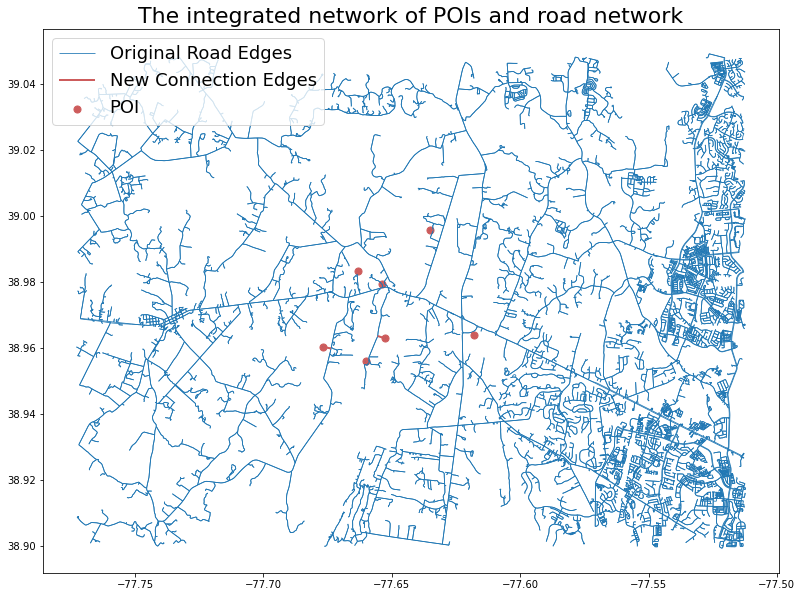

In [186]:
# output
# footways are added between the POIs and the closest lines
poi_links = edge_gdf[edge_gdf['highway'] == 'projected_footway']
ax = edges.plot(linewidth=0.8, figsize=(18,10), label='Original Road Edges')
poi_links.plot(color='indianred', linewidth=2, ax=ax, label='New Connection Edges')
POIs.plot(color='indianred', marker='.', markersize=200, ax=ax, label='POI')
ax.legend(loc=2, fontsize=18)
ax.set_title('The integrated network of POIs and road network', fontsize=22);

In [ ]:
new_edges.to_file("new_edges.shp")

In [ ]:
dfmi = pd.DataFrame([list('abcd'),
list('efgh'),
list('ijkl'),
list('mnop')],
columns=pd.MultiIndex.from_product([['one', 'two'],
['first', 'second']]))

In [ ]:
dfmi

In [ ]:
dfmi['one']['second']

In [ ]:
dfmi.loc[:, ('one', 'second')]

In [ ]:
dfmi['one']

In [ ]:
dfb = pd.DataFrame({'a': ['one', 'one', 'two',
'three', 'two', 'one', 'six'],
'c': np.arange(7)})

In [ ]:
dfb

In [ ]:
dfb['c'][dfb['a'].str.startswith('o')] = 42

In [ ]:
dfb